<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/6_1_both_models_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from imblearn.under_sampling import RandomUnderSampler


In [ ]:
data = pd.read_excel("full_data_BOTH_models_with_predictions_V.xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [ ]:
# raap = pd.read_csv("RAAP.csv")

In [ ]:
data.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model',
       'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?',
       'גוף המסמך חתוך מסווג שני', 'prediction_second_model',
       'second_model_predicted_probability',
       'prediction_second_model_adjusted\nערעור התקבל?',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'קידוד', 'הערות '],
      dtype='object')

In [ ]:
data['רע"פ בקשה אחרת או דלמטה מיוחד'].value_counts()
data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'בקשה אחרת') | (data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'דלמטה מיוחד')].shape[0]

65

In [ ]:
data = data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'בקשה אחרת') & (data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'דלמטה מיוחד')]

In [ ]:
check_data = data[[
       'בקשה לרשות ערעור התקבלה?',
       'הערעור התקבל?']]

In [ ]:
check_data[check_data['בקשה לרשות ערעור התקבלה?'].isnull()]

,בקשה לרשות ערעור התקבלה?,הערעור התקבל?
8,NaN,NaN
13,NaN,NaN
21,NaN,NaN
22,NaN,NaN
27,NaN,NaN
...,...,...
2956,NaN,NaN
2957,NaN,NaN
2958,NaN,NaN
2959,NaN,NaN


In [ ]:
check_data[check_data[ 'הערעור התקבל?'].isnull()]

,בקשה לרשות ערעור התקבלה?,הערעור התקבל?
5,נדחה,NaN
6,נדחה,NaN
8,NaN,NaN
13,NaN,NaN
19,נדחה,NaN
...,...,...
2956,NaN,NaN
2957,NaN,NaN
2958,NaN,NaN
2959,NaN,NaN


In [ ]:
clean_data=data[~data['בקשה לרשות ערעור התקבלה?'].isnull()]

In [ ]:
clean_data[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'predicted_probability',
       'prediction_original_model',
       'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?', 'prediction_second_model',
       'second_model_predicted_probability',
       'prediction_second_model_adjusted\nערעור התקבל?',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'הערות ']]

,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,predicted_probability,prediction_original_model,prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?,prediction_second_model,second_model_predicted_probability,prediction_second_model_adjusted\nערעור התקבל?,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**),הערעור התקבל?,הערות תוצאת ערעור,הערות
1,"['פסק דין בתיק רע""פ 1917/18 בבית המשפט העליון ...","רע""פ 1917/18","רע""פ 1917/18 אחמד אבו סבית נ. מדינת ישראל",2018,0.824141,1,1,1.0,0.990648,1.0,התקבל,NaN,התקבל,"נו מקבלים את הערעור, כאמור במובן זה שהתיק יוחז...",NaN
5,"['החלטה בתיק רע""פ 4873/14 בבית המשפט העליון רע...","רע""פ 4873/14","רע""פ 4873/14 מאיר פיסו נ. עופר אריאלי",2014,0.801372,1,1,1.0,0.665867,0.0,נדחה,"סבורני, כי אין מקום להיעתר לבקשה, מאחר שמדובר ...",NaN,NaN,NaN
6,"['פסק דין בתיק רע""פ 3842/14 בבית המשפט העליון ...","רע""פ 3842/14","רע""פ 3842/14 מוחמד עלאוי נ. הוועדה המקומית לתכ...",2014,0.929815,1,1,1.0,0.990764,1.0,נדחה,נוכח האמור בפיסקה 1 שלעיל – בקשת רשות הערעור נ...,NaN,NaN,NaN
7,"['פסק דין בתיק רע""פ 2875/14 בבית המשפט העליון ...","רע""פ 2875/14","רע""פ 2875/14 יואב קייסי נ. מדינת ישראל",2014,0.821090,1,1,1.0,0.998652,1.0,חלקי,בקשת הרשות לערער נענית רק לענין גובה הקנס.,חלקי,בקשת הרשות לערער נענית רק לענין גובה הקנס. הקנ...,NaN
11,"['פסק דין בתיק רע""פ 3296/14 בבית המשפט העליון ...","רע""פ 3296/14","רע""פ 3296/14 מיתקאל עיאשי נ. עיאשי אחסאנ",2014,0.974469,1,1,1.0,0.999967,1.0,התקבל,NaN,התקבל,"פס""ד בעניין סמכות שיפוט מבוטל ולכן התיק מוחזר ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,"['החלטה בתיק רע""פ 133/13 בבית המשפט העליון רע""...","רע""פ 133/13","רע""פ 133/13 ציקו עבדי נ. מדינת ישראל",2013,0.201271,0,0,NaN,NaN,NaN,נדחה,NaN,NaN,NaN,NaN
2581,"['החלטה בתיק רע""פ 182/13 בבית המשפט העליון רע""...","רע""פ 182/13","רע""פ 182/13 נעמ משה נ. מדינת ישראל",2013,0.047010,0,0,NaN,NaN,NaN,נדחה,NaN,NaN,NaN,NaN
2699,"['החלטה בתיק רע""פ 1370/17 בבית המשפט העליון רע...","רע""פ 1370/17","רע""פ 1370/17",2017,0.028190,0,0,NaN,NaN,NaN,נדחה,NaN,NaN,NaN,NaN
2713,"['החלטה בתיק רע""פ 3183/17 בבית המשפט העליון רע...","רע""פ 3183/17","רע""פ 3183/17 יואל קרויז נ. מדינת ישראל",2017,0.112401,0,0,NaN,NaN,NaN,נדחה,NaN,NaN,NaN,NaN


In [ ]:
 clean_data['בקשה לרשות ערעור התקבלה?'].unique()

array(['התקבל', 'נדחה', 'חלקי', 'אחר'], dtype=object)

In [ ]:
clean_data["prediction_second_model_adjusted\nערעור התקבל?"].unique()

array([ 1.,  0., nan])

In [ ]:
clean_data = data[(data['בקשה לרשות ערעור התקבלה?'] != 'אחר')]

In [ ]:
clean_data.dropna(subset=["בקשה לרשות ערעור התקבלה?"],inplace=True)

<ipython-input-15-eb4b6f54d70e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data.dropna(subset=["בקשה לרשות ערעור התקבלה?"],inplace=True)


In [ ]:
clean_data['binary_outcome_for_first_classifier'] = clean_data['בקשה לרשות ערעור התקבלה?'].apply(lambda x: 0 if x == 'נדחה' else 1)

<ipython-input-16-c8b97bc14048>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['binary_outcome_for_first_classifier'] = clean_data['בקשה לרשות ערעור התקבלה?'].apply(lambda x: 0 if x == 'נדחה' else 1)


In [ ]:
clean_data['binary_outcome_for_first_classifier'].unique()

array([1, 0])

In [ ]:
clean_data

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?,...,second_model_predicted_probability,prediction_second_model_adjusted\nערעור התקבל?,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**),הערעור התקבל?,הערות תוצאת ערעור,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,הערות,binary_outcome_for_first_classifier
1,152,152,"['פסק דין בתיק רע""פ 1917/18 בבית המשפט העליון ...","רע""פ 1917/18","רע""פ 1917/18 אחמד אבו סבית נ. מדינת ישראל",2018,"יה היעדר ההתייחסות לטענתו של המבקש, אשר נוגעת ...",0.824141,1,1,...,0.990648,1.0,התקבל,NaN,התקבל,"נו מקבלים את הערעור, כאמור במובן זה שהתיק יוחז...",NaN,גל,NaN,1
5,335,521,"['החלטה בתיק רע""פ 4873/14 בבית המשפט העליון רע...","רע""פ 4873/14","רע""פ 4873/14 מאיר פיסו נ. עופר אריאלי",2014,המטיל על הממרה קנס או מאסר. 5. בשולי הדברים א...,0.801372,1,1,...,0.665867,0.0,נדחה,"סבורני, כי אין מקום להיעתר לבקשה, מאחר שמדובר ...",NaN,NaN,NaN,גל,NaN,0
6,359,545,"['פסק דין בתיק רע""פ 3842/14 בבית המשפט העליון ...","רע""פ 3842/14","רע""פ 3842/14 מוחמד עלאוי נ. הוועדה המקומית לתכ...",2014,"ה: עו""ד עמית אופק פסק דין 1. בעקבות הערות בית ...",0.929815,1,1,...,0.990764,1.0,נדחה,נוכח האמור בפיסקה 1 שלעיל – בקשת רשות הערעור נ...,NaN,NaN,NaN,גל,NaN,0
7,362,548,"['פסק דין בתיק רע""פ 2875/14 בבית המשפט העליון ...","רע""פ 2875/14","רע""פ 2875/14 יואב קייסי נ. מדינת ישראל",2014,"ית ויעמוד על סך של 1,500 ש""ח. 2. נוכח ההודעה ש...",0.821090,1,1,...,0.998652,1.0,חלקי,בקשת הרשות לערער נענית רק לענין גובה הקנס.,חלקי,בקשת הרשות לערער נענית רק לענין גובה הקנס. הקנ...,NaN,גל,NaN,1
11,389,575,"['פסק דין בתיק רע""פ 3296/14 בבית המשפט העליון ...","רע""פ 3296/14","רע""פ 3296/14 מיתקאל עיאשי נ. עיאשי אחסאנ",2014,הרנו לצדדים. 2. על רקע עמדה זו ובהסכמת הצדדים ...,0.974469,1,1,...,0.999967,1.0,התקבל,NaN,התקבל,"פס""ד בעניין סמכות שיפוט מבוטל ולכן התיק מוחזר ...",NaN,גל,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,2984,4266,"['החלטה בתיק רע""פ 133/13 בבית המשפט העליון רע""...","רע""פ 133/13","רע""פ 133/13 ציקו עבדי נ. מדינת ישראל",2013,"הבלתי חוקיים באורך רוח ראוי לציון, ואולי הבעי...",0.201271,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0
2581,3006,4288,"['החלטה בתיק רע""פ 182/13 בבית המשפט העליון רע""...","רע""פ 182/13","רע""פ 182/13 נעמ משה נ. מדינת ישראל",2013,"נית בגזר דינה, כהוא זה, מרף הענישה הראוי בנסיב...",0.047010,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0
2699,3140,7361,"['החלטה בתיק רע""פ 1370/17 בבית המשפט העליון רע...","רע""פ 1370/17","רע""פ 1370/17",2017,"סר. 9. אשר על כן, בקשת רשות הערעור נדחית בזאת....",0.028190,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0
2713,3154,7375,"['החלטה בתיק רע""פ 3183/17 בבית המשפט העליון רע...","רע""פ 3183/17","רע""פ 3183/17 יואל קרויז נ. מדינת ישראל",2017,"851/13 עודה נ\' מדינת ישראל (25.10.2015); ע""פ ...",0.112401,0,0,...,NaN,NaN,נדחה,NaN,NaN,NaN,NaN,דניאל,NaN,0


In [ ]:
clean_data.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model',
       'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?',
       'גוף המסמך חתוך מסווג שני', 'prediction_second_model',
       'second_model_predicted_probability',
       'prediction_second_model_adjusted\nערעור התקבל?',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'קידוד', 'הערות ', 'binary_outcome_for_first_classifier'],
      dtype='object')

In [ ]:
clean_data["בקשה לרשות ערעור התקבלה?"].isnull().sum()

0

In [ ]:


def create_CM(data,labeled_col, predicted_col):
    # יצירת confusion matrix
    cm = confusion_matrix(data[labeled_col], data[predicted_col])

    # הצגת תוצאות confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # ויזואליזציה של confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


Confusion Matrix:
[[52  2]
 [25 83]]


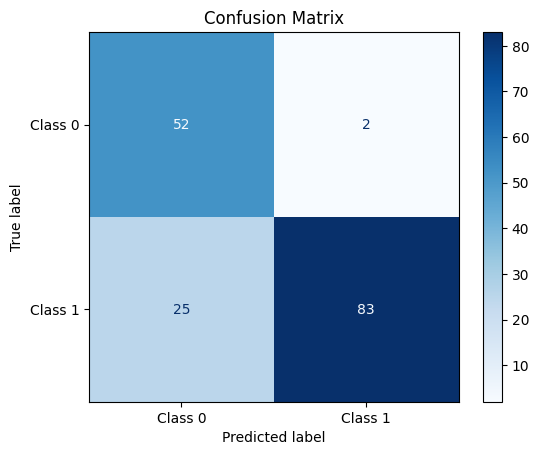

In [ ]:
create_CM(clean_data,"prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?",'binary_outcome_for_first_classifier')

In [ ]:
check_data = clean_data.dropna(subset=["הערעור התקבל?"])
check_data[check_data["prediction_second_model_adjusted\nערעור התקבל?"].isna()]

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?,...,second_model_predicted_probability,prediction_second_model_adjusted\nערעור התקבל?,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**),הערעור התקבל?,הערות תוצאת ערעור,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,הערות,binary_outcome_for_first_classifier
1346,1674,2618,"['פסק דין בתיק רע""פ 4753/08 בבית המשפט העליון ...","רע""פ 4753/08","רע""פ 4753/08 דמיטרי סנקובסקי נ. מדינת ישראל",2008,אנו מחליטים כדלקמן: בקשת רשות הערעור של המבקש...,0.592379,1,0,...,NaN,NaN,התקבל,"בקשת רשות הערעור של המבקש מתקבלת,",התקבל,"בקשת רשות הערעור של המבקש מתקבלת, וההחלטה המשל...",NaN,גל,NaN,1
2471,2886,4168,"['החלטה בתיק רע""פ 7888/13 בבית המשפט העליון רע...","רע""פ 7888/13","רע""פ 7888/13 עודד נחומ נ. מדינת ישראל",2013,"קירה, ונסמכת בעיקרה על מסכת העובדות מכתב האישו...",0.253042,0,0,...,NaN,NaN,התקבל,החלטנו לתת רשות ערעור כמבוקש ולדון בבקשה כבערע...,חלקי,במובן זה שאנו מזכים את המבקש מעבירת שיבוש מהלכ...,NaN,דניאל,NaN,1


In [ ]:
check_data['הערעור התקבל?'].unique()

array(['התקבל', 'חלקי', 'נדחה', 'אחר'], dtype=object)

In [ ]:
check_data[check_data['הערעור התקבל?']=="אחר"]

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?,...,second_model_predicted_probability,prediction_second_model_adjusted\nערעור התקבל?,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**),הערעור התקבל?,הערות תוצאת ערעור,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,הערות,binary_outcome_for_first_classifier
113,2084,3029,"['פסק דין בתיק רע""פ 4679/08 בבית המשפט העליון ...","רע""פ 4679/08","רע""פ 4679/08 חיימ לוי נ. מדינת ישראל",2008,נוצרה אי בהירות ביחס לדרך יישומו של פסק הדין כ...,0.941350,1,1,...,0.995802,1.0,התקבל,NaN,אחר,"נוכח השגגה שיצאה מתחת ידו של בית המשפט קמא, אנ...",NaN,גל,NaN,1
118,2143,3088,"['פסק דין בתיק רע""פ 5921/08 בבית המשפט העליון ...","רע""פ 5921/08","רע""פ 5921/08 רביע רג'בי נ. מדינת ישראל",2008,יעמדו בעינם. ההחלטה לעיכוב ביצוע עונש המאסר מי...,0.885901,1,1,...,0.988814,1.0,חלקי,החלטנו להיעתר לבקשה לרשות ערעור ולראותה כאילו ...,אחר,"ראינו לנכון להקל במעט בעונש שהושת עליו, כך שא...",NaN,גל,NaN,1
129,2281,3563,"['פסק דין בתיק רע""פ 1793/09 בבית המשפט העליון ...","רע""פ 1793/09","רע""פ 1793/09 פאבל מינסטר נ. מדינת ישראל",2009,"נשיא השופט ז\' המר, ס. הנשיא השופטת ב\' אופיר-...",0.917877,1,1,...,0.957767,0.0,התקבל,NaN,אחר,NaN,NaN,דניאל,ביהמש לא הכריע בערעור והחזיר לדיון נוסף במחוזי,1
131,2285,3567,"['פסק דין בתיק רע""פ 5066/09 בבית המשפט העליון ...","רע""פ 5066/09","רע""פ 5066/09 ירונ אוחיונ נ. מדינת ישראל",2009,"במקומו. ב. ולבסוף, אצטרף לדברי חברי בסיפת דברי...",0.953114,1,1,...,0.734142,0.0,התקבל,NaN,אחר,אין מידע על תוצאות הערעור,NaN,דניאל,NaN,1
180,2985,4267,"['פסק דין בתיק רע""פ 4384/13 בבית המשפט העליון ...","רע""פ 4384/13","רע""פ 4384/13 מדינת ישראל נ. מיאו והאו בע""מ",2013,"ם, ככל שהמשיבים יורשעו בדין. נוכח לוח הזמנים ה...",0.976018,1,1,...,0.998196,1.0,התקבל,NaN,אחר,עניינם של המבקשים יובא בשנית בפני בית המשפט המ...,NaN,דניאל,NaN,1
183,3032,4314,"['פסק דין בתיק רע""פ 655/13 בבית המשפט העליון ר...","רע""פ 655/13","רע""פ 655/13 ראובנ יאיר נ. מדינת ישראל",2013,ד אופיר טישלר פסק דין משלים בהמשך לפסק דיננו מ...,0.797494,1,1,...,0.998034,1.0,התקבל,NaN,אחר,"בהמשך לפסק דיננו מיום 4.3.2013, הננו קובעים כי...",NaN,דניאל,אין מספיק מידע על בקשת הערעור כדי לקבוע האם הת...,1


In [ ]:
check_data = check_data[check_data['הערעור התקבל?']!="אחר"]

In [ ]:
check_data['הערעור התקבל?'].unique()

array(['התקבל', 'חלקי', 'נדחה'], dtype=object)

In [ ]:
check_data['binary_outcome_for_second_classifier'] = clean_data['הערעור התקבל?'].apply(lambda x: 0 if x == 'נדחה' else 1)

In [ ]:
check_data["prediction_second_model_adjusted\nערעור התקבל?"].isna()

,prediction_second_model_adjusted\nערעור התקבל?
1,False
7,False
11,False
14,False
15,False
...,...
193,False
199,False
203,False
1346,True


In [ ]:
check_data.dropna(subset=["prediction_second_model_adjusted\nערעור התקבל?"],inplace = True)

Confusion Matrix:
[[ 5  8]
 [ 4 63]]


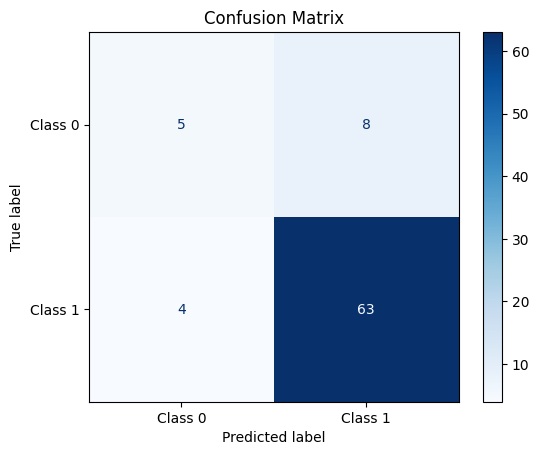

In [ ]:
create_CM(check_data.dropna(subset=["prediction_second_model_adjusted\nערעור התקבל?"]),'prediction_second_model_adjusted\nערעור התקבל?','binary_outcome_for_second_classifier')

In [ ]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import joblib
import pandas as pd

# טעינת המודל והטוקנייזר
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

### Embedding

In [ ]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib


# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])


### Train and fit

In [ ]:
# classifier_model_second_undersampled

In [ ]:
X = embeddings
# טוען את המודל
classifier = joblib.load("classifier_model_double_trained.pkl")

print("המודל נטען בהצלחה.")

# התאמת המודל לנתונים המאוזנים
classifier.fit(X, y)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X, y, cv=5)
conf_matrix = confusion_matrix(y, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")


# --- שמירת משאבים ---
joblib.dump(classifier, '2_classifier_model_double_trained.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


המודל נטען בהצלחה.
Cross-Validation Accuracy: [0.93939394 0.96875    0.875      0.625      0.96875   ]
Mean Accuracy: 0.8753787878787879
Cross-Validation Precision for Class 1: [0.8        1.         0.8        0.30769231 1.        ]
Mean Precision for Class 1: 0.7815384615384616
Cross-Validation Recall for Class 1: [1.         0.85714286 0.57142857 0.57142857 0.85714286]
Mean Recall for Class 1: 0.7714285714285715
Cross-Validation F1 Score for Class 1: [0.88888889 0.92307692 0.66666667 0.4        0.92307692]
Mean F1 Score for Class 1: 0.7603418803418803
Confusion Matrix with Labels:
True Negatives (TN): 113
False Positives (FP): 12
False Negatives (FN): 8
True Positives (TP): 28

Confusion Matrix:
[[113 12]
 [8 28]]
המודל והמשאבים נשמרו בהצלחה.


In [ ]:
# X = embeddings
# # טוען את המודל
# classifier = joblib.load("classifier_model_second_undersampled.pkl")

# print("המודל נטען בהצלחה.")

# # התאמת המודל לנתונים המאוזנים
# classifier.fit(X, y)

# # הגדרת מדדים לקרוס ולידציה
# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'precision': make_scorer(precision_score, pos_label=1),
#     'recall': make_scorer(recall_score, pos_label=1),
#     'f1': make_scorer(f1_score, pos_label=1)
# }

# # ביצוע Cross Validation
# cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)

# # חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
# y_pred = cross_val_predict(classifier, X, y, cv=5)
# conf_matrix = confusion_matrix(y, y_pred)

# # הדפסת התוצאות
# print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
# print("Mean Accuracy:", cv_results['test_accuracy'].mean())
# print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
# print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
# print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
# print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
# print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
# print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

# tn, fp, fn, tp = conf_matrix.ravel()

# # הדפסת הקונפיושן מטריקס עם תוויות
# print("Confusion Matrix with Labels:")
# print(f"True Negatives (TN): {tn}")
# print(f"False Positives (FP): {fp}")
# print(f"False Negatives (FN): {fn}")
# print(f"True Positives (TP): {tp}")

# print("\nConfusion Matrix:")
# print(f"[[{tn} {fp}]")
# print(f" [{fn} {tp}]]")


# # # --- שמירת משאבים ---
# # joblib.dump(classifier, '2_classifier_model_double_trained.pkl')

# # print("המודל והמשאבים נשמרו בהצלחה.")


In [ ]:
# # חיזוי הסתברויות לכל קפל לצורך שינוי סף
# y_prob = cross_val_predict(classifier, X, y, cv=5, method='predict_proba')[:, 1]

# # קביעת סף חדש
# threshold = 0.1
# y_pred = (y_prob >= threshold).astype(int)

# # יצירת קונפיושן מטריקס
# conf_matrix = confusion_matrix(y, y_pred)
# # חישוב מדדים עם הסף החדש
# accuracy = accuracy_score(y, y_pred)
# precision = precision_score(y, y_pred, pos_label=1)
# recall = recall_score(y, y_pred, pos_label=1)
# f1 = f1_score(y, y_pred, pos_label=1)

# print("\nמדדים לאחר שינוי סף הסיווג:")
# print(f"Accuracy: {accuracy:.3f}")
# print(f"Precision for Class 1: {precision:.3f}")
# print(f"Recall for Class 1: {recall:.3f}")
# print(f"F1 Score for Class 1: {f1:.3f}")

# # # הדפסת התוצאות
# # print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
# # print("Mean Accuracy:", cv_results['test_accuracy'].mean())
# # print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
# # print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
# # print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
# # print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
# # print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
# # print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

# tn, fp, fn, tp = conf_matrix.ravel()

# # הדפסת הקונפיושן מטריקס עם תוויות
# print("Confusion Matrix with Labels:")
# print(f"True Negatives (TN): {tn}")
# print(f"False Positives (FP): {fp}")
# print(f"False Negatives (FN): {fn}")
# print(f"True Positives (TP): {tp}")

# print("\nConfusion Matrix:")
# print(f"[[{tn} {fp}]")
# print(f" [{fn} {tp}]]")

# # --- שמירת משאבים ---
# # joblib.dump(classifier, '2_classifier_model_double_trained.pkl')

# # print("המודל והמשאבים נשמרו בהצלחה.")

### FN print


In [ ]:

# # איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
# fn_indices = np.where((y == 1) & (y_pred == 0))[0]


# # קריאת השורות הרלוונטיות מה-DataFrame
# false_negative_rows = data.iloc[fn_indices]

# # ווידוא סינכרון מוחלט של האינדקסים
# if len(false_negative_rows) != len(fn_indices):
#     raise ValueError("Mismatch between FN rows and FN indices!")

# # הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
# print("False Negative Cases (True Label: 1, Predicted Label: 0):")
# print("=" * 80)

# for i, (index, row) in enumerate(false_negative_rows.iterrows(), 1):
#     print(f"\nCase {i}:")
#     print("-" * 80)
#     print("Index in Original Data:")
#     print(index)

#     # הדפסת binary_outcome (תווית אמיתית)
#     print("\nBinary Outcome (True Label):")
#     print(row["binary_outcome"])

#     # הדפסת התחזית (Predicted Label)
#     print("\nPredicted Label:")
#     print(0)  # FN משמעותו שהתחזית היא 0

#     # הדפסת גוף המסמך אם קיים
#     if "גוף המסמך" in row:
#         print("\nDocument Body:")
#         formatted_text = "\n".join(row["גוף המסמך"][j:j + 80] for j in range(0, len(row["גוף המסמך"]), 80))
#         print(formatted_text)
#     else:
#         print("\nDocument Body: Not Available")

#     # הדפסת גוף המסמך חתוך אם קיים
#     if "גוף המסמך חתוך" in row:
#         print("\nDocument Body (Trimmed):")
#         formatted_text_trimmed = "\n".join(row["גוף המסמך חתוך"][j:j + 80] for j in range(0, len(row["גוף המסמך חתוך"]), 80))
#         print(formatted_text_trimmed)
#     else:
#         print("\nDocument Body (Trimmed): Not Available")

#     # הדפסת שאר העמודות הרלוונטיות
#     relevant_columns = [
#         "בקשה לרשות ערעור התקבלה?", "טקסט שמצביע על תוצאת בקשה שונה",
#         "הערעור התקבל?", "רע\"פ בקשה אחרת או דלמטה מיוחד",
#         "קידוד", "קידוד חוזר", "הערות", "הערות קידוד חוזר"
#     ]
#     print("\nRelevant Columns Data:")
#     for col in relevant_columns:
#         if col in row:
#             print(f"{col}: {row[col]}")
#         else:
#             print(f"{col}: Not Available")

#     print("-" * 80)

# print("=" * 80)


In [ ]:
# # חיזוי תוויות על כל קפל לצורך זיהוי FP
# y_pred = cross_val_predict(classifier, X, y, cv=5)

# # איתור האינדקסים של FP - תווית אמיתית היא 0 והתחזית היא 1
# fp_indices = np.where((y == 0) & (y_pred == 1))[0]


# # קריאת השורות הרלוונטיות מה-DataFrame
# false_positive_rows = data.iloc[fp_indices]

# # ווידוא סינכרון מוחלט של האינדקסים
# if len(false_positive_rows) != len(fp_indices):
#     raise ValueError("Mismatch between FP rows and FP indices!")

# # הדפסת פסקי הדין של FP בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
# print("False Positive Cases (True Label: 0, Predicted Label: 1):")
# print("=" * 80)

# for i, (index, row) in enumerate(false_positive_rows.iterrows(), 1):
#     print(f"\nCase {i}:")
#     print("-" * 80)
#     print("Index in Original Data:")
#     print(index)

#     # הדפסת binary_outcome (תווית אמיתית)
#     print("\nBinary Outcome (True Label):")
#     print(row["binary_outcome"])

#     # הדפסת התחזית (Predicted Label)
#     print("\nPredicted Label:")
#     print(1)  # FP משמעותו שהתחזית היא 1

#     # הדפסת גוף המסמך אם קיים
#     if "גוף המסמך" in row:
#         print("\nDocument Body:")
#         formatted_text = "\n".join(row["גוף המסמך"][j:j + 80] for j in range(0, len(row["גוף המסמך"]), 80))
#         print(formatted_text)
#     else:
#         print("\nDocument Body: Not Available")

#     # הדפסת גוף המסמך חתוך אם קיים
#     if "גוף המסמך חתוך" in row:
#         print("\nDocument Body (Trimmed):")
#         formatted_text_trimmed = "\n".join(row["גוף המסמך חתוך"][j:j + 80] for j in range(0, len(row["גוף המסמך חתוך"]), 80))
#         print(formatted_text_trimmed)
#     else:
#         print("\nDocument Body (Trimmed): Not Available")

#     # הדפסת שאר העמודות הרלוונטיות
#     relevant_columns = [
#         "בקשה לרשות ערעור התקבלה?", "טקסט שמצביע על תוצאת בקשה שונה",
#         "הערעור התקבל?", "רע\"פ בקשה אחרת או דלמטה מיוחד",
#         "קידוד", "קידוד חוזר", "הערות", "הערות קידוד חוזר"
#     ]
#     print("\nRelevant Columns Data:")
#     for col in relevant_columns:
#         if col in row:
#             print(f"{col}: {row[col]}")
#         else:
#             print(f"{col}: Not Available")

#     print("-" * 80)

# print("=" * 80)


Undersampling

In [ ]:

# # הגדרת undersampler עם יחס של60-40 לטובת קלאס 0
# undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# # שמירת אינדקסים מקוריים
# resampled_indices = undersampler.sample_indices_
# joblib.dump(resampled_indices, 'resampled_indices.pkl')

# # ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
# binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
# if not np.array_equal(y_resampled, binary_outcome_resampled):
#     raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# # הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
# classifier = joblib.load("classifier_model.pkl")

# # התאמת המודל לנתונים המאוזנים
# classifier.fit(X_resampled, y_resampled)

# # הגדרת מדדים לקרוס ולידציה
# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'precision': make_scorer(precision_score, pos_label=1),
#     'recall': make_scorer(recall_score, pos_label=1),
#     'f1': make_scorer(f1_score, pos_label=1)
# }

# # ביצוע Cross Validation
# cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# # חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
# y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
# conf_matrix = confusion_matrix(y_resampled, y_pred)

# # הדפסת התוצאות
# print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
# print("Mean Accuracy:", cv_results['test_accuracy'].mean())
# print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
# print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
# print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
# print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
# print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
# print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

# tn, fp, fn, tp = conf_matrix.ravel()

# # הדפסת הקונפיושן מטריקס עם תוויות
# print("Confusion Matrix with Labels:")
# print(f"True Negatives (TN): {tn}")
# print(f"False Positives (FP): {fp}")
# print(f"False Negatives (FN): {fn}")
# print(f"True Positives (TP): {tp}")

# print("\nConfusion Matrix:")
# print(f"[[{tn} {fp}]")
# print(f" [{fn} {tp}]]")

# # --- לוגיקה למציאת threshold אופטימלי ---
# predicted_probabilities = classifier.predict_proba(X_resampled)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_resampled, predicted_probabilities)
# f1_scores = 2 * (precision * recall) / (precision + recall)
# optimal_threshold = thresholds[np.argmax(f1_scores)]
# print(f"Threshold אופטימלי לפי F1 Score: {optimal_threshold}")

# # שמירת יחס הכיתות המקורי
# class_ratio_original = sum(y == 1) / len(y)
# print(f"יחס כיתות מקורי (Class 1): {class_ratio_original:.2f}")

# # --- שמירת משאבים ---
# joblib.dump(classifier, '2_classifier_model_second_undersampled.pkl')
# joblib.dump(optimal_threshold, 'optimal_threshold.pkl')
# joblib.dump(class_ratio_original, 'class_ratio_original.pkl')

# print("המודל והמשאבים נשמרו בהצלחה.")


In [ ]:
# # חיזוי הסתברויות לכל קפל לצורך שינוי סף
# y_prob = cross_val_predict(classifier, X, y, cv=5, method='predict_proba')[:, 1]

# # קביעת סף חדש
# threshold = 0.1
# y_pred = (y_prob >= threshold).astype(int)

# # יצירת קונפיושן מטריקס
# conf_matrix = confusion_matrix(y, y_pred)
# # חישוב מדדים עם הסף החדש
# accuracy = accuracy_score(y, y_pred)
# precision = precision_score(y, y_pred, pos_label=1)
# recall = recall_score(y, y_pred, pos_label=1)
# f1 = f1_score(y, y_pred, pos_label=1)

# print("\nמדדים לאחר שינוי סף הסיווג:")
# print(f"Accuracy: {accuracy:.3f}")
# print(f"Precision for Class 1: {precision:.3f}")
# print(f"Recall for Class 1: {recall:.3f}")
# print(f"F1 Score for Class 1: {f1:.3f}")

# # # הדפסת התוצאות
# # print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
# # print("Mean Accuracy:", cv_results['test_accuracy'].mean())
# # print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
# # print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
# # print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
# # print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
# # print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
# # print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

# tn, fp, fn, tp = conf_matrix.ravel()

# # הדפסת הקונפיושן מטריקס עם תוויות
# print("Confusion Matrix with Labels:")
# print(f"True Negatives (TN): {tn}")
# print(f"False Positives (FP): {fp}")
# print(f"False Negatives (FN): {fn}")
# print(f"True Positives (TP): {tp}")

# print("\nConfusion Matrix:")
# print(f"[[{tn} {fp}]")
# print(f" [{fn} {tp}]]")

# # --- שמירת משאבים ---
# joblib.dump(classifier, '2_classifier_model_second_undersampled.pkl')

# print("המודל והמשאבים נשמרו בהצלחה.")